***Necessary Imports and further imports also there***

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from torch import nn
import pickle
import numpy as np
import pandas as pd

***Setting Seeds so results can be reproduced***

In [3]:
np.random_seet=42
torch.manual_seed=42

**Donwloading Datasets and transforming them**

In [4]:
#from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation

training_loader = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=256, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 109026166.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42879891.62it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25429717.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11781403.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Implementing SIFT detectors and Descriptors By using OpenCV's SIFT_create feature

In [ ]:
def sift_Default_Settings():
    sift=cv2.SIFT_create()
    sift.setContrastThreshold(0.25)
    sift.setEdgeThreshold(5)
    return sift

In [5]:
sift=sift_Default_Settings()

Getting Descriptors and Labels for the SIFT clusters

In [6]:
def get_descriptors_and_lables(dataloader_sp):
    images_desc=[]
    images_labels=[]
    img_not_recognized_by_sift=[]
    for data in dataloader_sp:
        d,l=data
        for i in range(d.size(0)):
            img=d[i][0,:,:]
            img=img.numpy().astype('uint8')
            kp,desc=sift.detectAndCompute(img,None)
            if desc is not None:
                images_desc.append(desc)
                images_labels.append(l[i])
    return images_desc,images_labels

In [7]:
desc,labels=get_descriptors_and_lables(training_loader)

KeyboardInterrupt: 

In [ ]:
train_desc=np.vstack(desc)

In [ ]:
train_desc.shape

In [ ]:
desc_test,labels_test=get_descriptors_and_lables(validation_loader)

In [12]:
len(labels_test)

9877

In [13]:
test_desc=np.vstack(desc_test)

**Creating SVM model for 10 way Classification**

In [14]:
def Kmeans_config(n_clusters):
    Kmcluster=KMeans(n_clusters=n_clusters)
    kmeans=Kmcluster.fit(train_desc)
    return kmeans

In [15]:
kmeans=Kmeans_config(5)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
kmeans.n_clusters

5

In [17]:
with open('./ntrain_wts.pkl','wb') as f:
    pickle.dump(kmeans,f)

In [18]:
def compute_img_cluster_centres(data,kmeans):
    in_features=np.array([np.zeros(kmeans.n_clusters) for i in range(len(data))])
    for i in range(len(data)):
        for j in data[i]:
            x_data=j
            x_data_for_kmeans=x_data.reshape(1,128)
            idx=kmeans.predict(x_data_for_kmeans)
            in_features[i][idx]+=1
    return in_features

In [19]:
in_features_train=compute_img_cluster_centres(desc,kmeans)

In [20]:
in_features_test=compute_img_cluster_centres(desc_test,kmeans)

**Representing Images as Histograms**

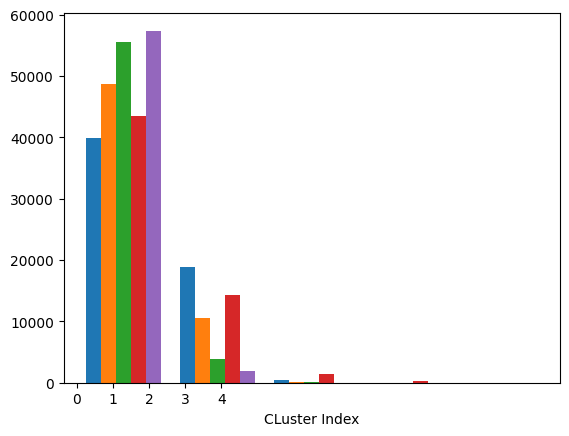

In [21]:
plt.hist(in_features_train,bins=5)
plt.xlabel('CLuster Index')
plt.xticks(range(kmeans.n_clusters))
plt.show()

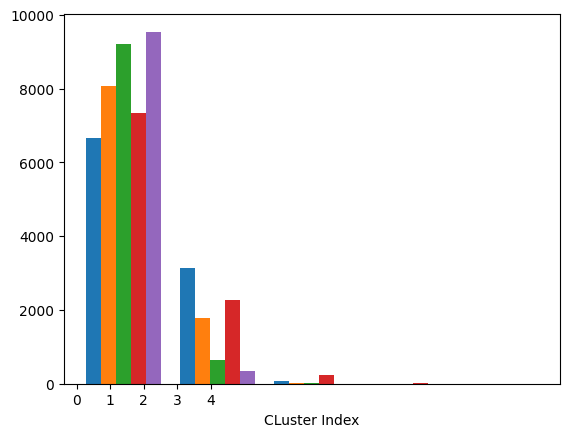

In [22]:
plt.hist(in_features_test,bins=kmeans.n_clusters)
plt.xlabel('CLuster Index')
plt.xticks(range(kmeans.n_clusters))
plt.show()

**Computing Acc Scores by taking n_clusters for SVM as 5**

In [23]:
standsc_train=StandardScaler().fit(in_features_train)
in_features_train=standsc_train.transform(in_features_train)

In [24]:
svm=SVC(kernel='linear',probability=True)

In [25]:
svm.fit(in_features_train,labels)

SVC(kernel='linear', probability=True)

In [26]:
train_preds=svm.predict(in_features_train)

In [27]:
accuracy_score(labels,train_preds)

0.3567298777918247

In [28]:
standsc_test=StandardScaler().fit(in_features_test)
in_features_test=standsc_train.transform(in_features_test)

In [29]:
test_preds=svm.predict(in_features_test)
accuracy_score(labels_test,test_preds)

0.3507137794876987

**Trying out with Different n_clusters values and keeping everything else constant**

In [33]:
def evaluate_acc_with_different_Kmeans(n_clusters):
    kmeans=Kmeans_config(n_clusters)
    in_features_train=compute_img_cluster_centres(desc,kmeans)
    in_features_test=compute_img_cluster_centres(desc_test,kmeans)
    standsc_train=StandardScaler().fit(in_features_train)
    in_features_train=standsc_train.transform(in_features_train)
    svm=SVC(kernel='linear',probability=True)
    svm.fit(in_features_train,labels)
    train_preds=svm.predict(in_features_train)
    train_acc_score=accuracy_score(labels,train_preds)
    standsc_test=StandardScaler().fit(in_features_test)
    in_features_test=standsc_train.transform(in_features_test)
    test_preds=svm.predict(in_features_test)
    test_acc_score=accuracy_score(labels_test,test_preds)
    return train_acc_score,test_acc_score

In [34]:

5

5

In [ ]:
z=[evaluate_acc_with_different_Kmeans(i) for i in [10,20,50,100,200,500]]

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

In [35]:
z

[(0.4348419721871049, 0.43748101650298676),
 (0.536047197640118, 0.5312341804191556),
 (0.6729540665823852, 0.6703452465323478),
 (0.7474926253687315, 0.7414194593500051),
 (0.8101474926253688, 0.7914346461476157),
 (0.8852928782132322, 0.8318315277918397)]

In [ ]:
j=0
for i in [10,20,50,100,200,500]:
    if j<=5:
        print('N_Clusters: '+i+z[j])
        j+=1
    else:
        break
    

**Tinkering with params such as kernel type reg_parameters and other things and seeing the effect on accuracy**

In [61]:
kmeans=Kmeans_config(100)
in_features_train=compute_img_cluster_centres(desc,kmeans)
in_features_test=compute_img_cluster_centres(desc_test,kmeans)
standsc_train=StandardScaler().fit(in_features_train)
in_features_train=standsc_train.transform(in_features_train)    

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [51]:
kmeans

KMeans(n_clusters=100)

In [63]:
in_features_train

array([[-0.2736607 , -0.26954643, -0.25566614, ..., -0.23289013,
        -0.25480407, -0.22005677],
       [-0.2736607 , -0.26954643, -0.25566614, ..., -0.23289013,
        -0.25480407, -0.22005677],
       [-0.2736607 , -0.26954643, -0.25566614, ..., -0.23289013,
        -0.25480407, -0.22005677],
       ...,
       [-0.2736607 , -0.26954643, -0.25566614, ..., -0.23289013,
         3.65019506, -0.22005677],
       [-0.2736607 , -0.26954643, -0.25566614, ..., -0.23289013,
        -0.25480407, -0.22005677],
       [-0.2736607 , -0.26954643, -0.25566614, ..., -0.23289013,
        -0.25480407, -0.22005677]])

In [64]:
def evaluate_acc_with_different_svm_config(in_features_train,in_features_test,reg_parameter=1.0,kernel_type='linear',degree=3,shrinking=True,tol=0.001):
    svm=SVC(kernel=kernel_type,C=reg_parameter,degree=degree,shrinking=shrinking,tol=tol,probability=True)
    svm.fit(in_features_train,labels)
    train_preds=svm.predict(in_features_train)
    train_acc_score=accuracy_score(labels,train_preds)
    standsc_test=StandardScaler().fit(in_features_test)
    in_features_test=standsc_train.transform(in_features_test)
    test_preds=svm.predict(in_features_test)
    test_acc_score=accuracy_score(labels_test,test_preds)
    return train_acc_score,test_acc_score

**Below are 6 different configs for which the accuracy is displayed**

Config1

In [66]:
train_acc,test_acc=evaluate_acc_with_different_svm_config(in_features_train,in_features_test,reg_parameter=1.5)
print(train_acc,test_acc)

0.7492456805731142 0.7457730079983801


Config2

In [67]:
train_acc,test_acc=evaluate_acc_with_different_svm_config(in_features_train,in_features_test,1.0,'linear',2)
print(train_acc,test_acc)

0.7491951116729878 0.7458742533157842


Config3

In [68]:
train_acc,test_acc=evaluate_acc_with_different_svm_config(in_features_train,in_features_test,2.0,'linear',3)
print(train_acc,test_acc)

0.7492119679730299 0.7455705173635719


COnfig4

In [69]:
train_acc,test_acc=evaluate_acc_with_different_svm_config(in_features_train,in_features_test,1.0,'linear',3,False)
print(train_acc,test_acc)

0.7491951116729878 0.745671762680976


Config5

In [ ]:
train_acc,test_acc=evaluate_acc_with_different_svm_config(in_features_train,in_features_test,2.0,'linear',3,True,1e-2)
print(train_acc,test_acc)

In [1]:
45

45

Config6

In [ ]:
train_acc,test_acc=evaluate_acc_with_different_svm_config(in_features_train,in_features_test,2.0,'linear',4,True,1e-2)
print(train_acc,test_acc)

**Creating a Basic mimicking of LeNet and using also using a simple Transformer Encoder layer to train and test on MNIST dataset**

In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'

**Seting Up WandB logging and everything else**

In [5]:
import wandb
from pprint import pprint
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [56]:
from torchmetrics import Accuracy, Precision, Recall, F1Score
num_classes = 10
accuracy = Accuracy(task='multiclass',num_classes=num_classes).to(device)
precision = Precision(task='multiclass', average='macro', num_classes=num_classes).to(device)
recall = Recall(task='multiclass', average='macro', num_classes=num_classes).to(device)
f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes).to(device)

In [6]:
run=wandb.init(project='CV-Assn2')

wandb: Currently logged in as: anshulsharma2323 (ttm-me). Use `wandb login --relogin` to force relogin


In [14]:
wandb.config.learning_rate=1e-3
wandb.config.batch_size=256
wandb.config.epoch=10

In [57]:
from tqdm import tqdm

**Creating A Lenet by using pytorch's conv2d**

In [58]:
class Lenet(torch.nn.Module):
    def __init__(self):
        super(Lenet,self).__init__()
        self.forward_method=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=0),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            #nn.Sigmoid(),
            nn.Conv2d(6,16,kernel_size=5,stride=1,padding=0),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Flatten(),
            nn.Linear(16*5*5,120),
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,10))
    def forward(self,img_data):
        return self.forward_method(img_data)
        

In [22]:
#from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(32,antialias=True),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation

training_loader = torch.utils.data.DataLoader(training_set, batch_size=8192, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=8192, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 127018936.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34511593.68it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33324939.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6457806.36it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Defined Sweep configs for WandB Configs**

In [45]:
sweep_config={
    'method':'random',
    'metric':{
        'name':'loss',
        'goal':'minimize'
    },
    'parameters':{
        'learning_rate':{
            'values':[1e-4,1e-3,1e-2,1e-1]
        },
        'optimizer':{
            'values':['sgd','adam']
        },
        'batch_size':{
           'values': [512,1024,2048,8192,4096,]
        },
        'epochs':{
            'values':[5,10,15,20,25,30]
        }
    }
}

In [59]:
def build_optimizer(model, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(),
                               lr=learning_rate)
    return optimizer

In [49]:
def create_model():
    return Lenet().to(device)

In [60]:
def train_epoch(model,dataloader1,dataloader2,optimizer,device):
    loss_train=0
    accuracy_train=0
    loss_eval=0
    accuracy_eval=0
    loss_fn=torch.nn.CrossEntropyLoss()
    model.train()
    for batch_dl in dataloader1:
        d,l=batch_dl
        optimizer.zero_grad()
        out=model(d.to(device))
        bloss=loss_fn(out,l.to(device))
        bloss.backward()
        optimizer.step()
        loss_train+=bloss.item()
        preds=torch.argmax(out,dim=1)
        accuracy_train+=accuracy(preds,l.to(device))
    wandb.log({'epoch loss train':loss_train,'accuracy train':accuracy_train/len(dataloader1)})
    model.eval()
    with torch.no_grad():
        for batch_dl in dataloader2:
            d,l=batch_dl
            out=model(d.to(device))
            bloss=loss_fn(out,l.to(device))
            loss_eval+=bloss.item()
            preds=torch.argmax(out,dim=1)
            accuracy_eval+=accuracy(preds,l.to(device))
    wandb.log({'epoch loss test':loss_eval,'accuracy test':accuracy_eval/len(dataloader2)})
    return loss_train,accuracy_train,loss_eval,accuracy_eval

In [61]:
def create_dataloader(dataset_type1=None,dataset_type2=None,batch_size=0):
    training_loader = torch.utils.data.DataLoader(dataset_type1, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset_type2, batch_size=batch_size, shuffle=False)
    return training_loader,validation_loader

In [62]:
def train(config=None):
    with wandb.init(config=config):
        config=wandb.config
        model=create_model()
        dataloader1,dataloader2=create_dataloader(training_set,validation_set,config.batch_size)
        optimizer=build_optimizer(model,config.optimizer,config.learning_rate)
        for epoch in range(config.epochs):
            tr_l,ac_tr,ev_l,ac_ev=train_epoch(model,dataloader1,dataloader2,optimizer,device)

In [53]:
sweep_id=wandb.sweep(sweep_config,project='CV-Assn2')

Create sweep with ID: rjih81jb
Sweep URL: https://wandb.ai/ttm-me/CV-Assn2/sweeps/rjih81jb


**Results for Different WandB Sweeps**

In [ ]:
wandb.agent(sweep_id, function=train, count=6)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: y27bif8z with config:
wandb: 	batch_size: 8192
wandb: 	epochs: 25
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


accuracy test,▁▁▁▁▁████████████████████
accuracy train,▁▁▁▁▁▅████▇████▇████████▇
epoch loss test,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch loss train,█▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy test,0.1141
accuracy train,0.11175
epoch loss test,4.59826
epoch loss train,18.40119


wandb: Agent Starting Run: 34blz4e9 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


accuracy test,▁▁▁▃▄▅▅▆▆▇▇▇▇███████
accuracy train,▁▁▁▁▃▄▅▆▆▆▇▇▇▇██████
epoch loss test,████▇▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁
epoch loss train,█████▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁
accuracy test,0.875
accuracy train,0.86958
epoch loss test,9.65989
epoch loss train,59.82677


wandb: Agent Starting Run: q93gmt86 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


accuracy test,▁▇▇▇████████████████
accuracy train,▁▅▇▇████████████████
epoch loss test,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch loss train,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy test,0.98332
accuracy train,0.98393
epoch loss test,1.04916
epoch loss train,6.38093


wandb: Agent Starting Run: k0zcadn6 with config:
wandb: 	batch_size: 2048
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


accuracy test,▁█████████████████████████████
accuracy train,▁▅███▇████▇█▇▇██▇█▇██▇███▇████
epoch loss test,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch loss train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy test,0.11354
accuracy train,0.11216
epoch loss test,11.50498
epoch loss train,69.03522


wandb: Agent Starting Run: o9o73h2u with config:
wandb: 	batch_size: 4096
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


accuracy test,▁█████████████████████████████
accuracy train,▄▁████████████████████████████
epoch loss test,█▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch loss train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy test,0.11379
accuracy train,0.11226
epoch loss test,6.90231
epoch loss train,34.5188


wandb: Agent Starting Run: 1rhyezyd with config:
wandb: 	batch_size: 1024
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Q 2.1

In [7]:
api=wandb.Api()
run=api.run('ttm-me/CV-Assn2/runs/1rhyezyd')


In [8]:
run.config

{'epochs': 5, 'optimizer': 'adam', 'batch_size': 1024, 'learning_rate': 0.001}

In [9]:
from IPython.display import IFrame
display(IFrame(run.url,1000,1000))

In [41]:
run.history()

,epoch loss train,_step,_runtime,_timestamp,accuracy test,accuracy train,epoch loss test
0,136.192268,0,50.890613,1.709824e+09,NaN,0.106608,NaN
1,NaN,1,54.126768,1.709824e+09,0.113650,NaN,23.007958
2,133.831310,2,73.630110,1.709824e+09,NaN,0.170782,NaN
3,NaN,3,76.761102,1.709824e+09,0.362478,NaN,21.143330
4,94.939584,4,95.957957,1.709824e+09,NaN,0.556262,NaN
5,NaN,5,99.101772,1.709824e+09,0.742315,NaN,10.472127
6,45.911885,6,118.395652,1.709824e+09,NaN,0.808982,NaN
7,NaN,7,121.528927,1.709824e+09,0.858249,NaN,5.694290
8,28.813768,8,140.891505,1.709824e+09,NaN,0.873427,NaN
9,NaN,9,143.992184,1.709824e+09,0.892815,NaN,4.020850


Q 2.2

In [10]:
run=api.run('ttm-me/CV-Assn2/runs/o9o73h2u')
run.config

{'epochs': 30, 'optimizer': 'sgd', 'batch_size': 4096, 'learning_rate': 0.01}

In [11]:
run.url

'https://wandb.ai/ttm-me/CV-Assn2/runs/o9o73h2u'

In [12]:
from IPython.display import IFrame
display(IFrame(run.url,1000,1000))

In [13]:
run=api.run('ttm-me/CV-Assn2/runs/k0zcadn6')
print(run.config)
IFrame(run.url,1000,1000)

{'epochs': 30, 'optimizer': 'sgd', 'batch_size': 2048, 'learning_rate': 0.001}


In [14]:
run=api.run('ttm-me/CV-Assn2/runs/k0zcadn6')
print(run.config)
IFrame(run.url,1000,1000)

{'epochs': 30, 'optimizer': 'sgd', 'batch_size': 2048, 'learning_rate': 0.001}


In [15]:
run=api.run('ttm-me/CV-Assn2/runs/q93gmt86')
print(run.config)
IFrame(run.url,1000,1000)

{'epochs': 20, 'optimizer': 'adam', 'batch_size': 512, 'learning_rate': 0.001}


In [16]:
run=api.run('ttm-me/CV-Assn2/runs/34blz4e9')
print(run.config)
IFrame(run.url,1000,1000)

{'epochs': 20, 'optimizer': 'adam', 'batch_size': 512, 'learning_rate': 0.0001}


In [17]:
run=api.run('ttm-me/CV-Assn2/runs/y27bif8z')
print(run.config)
IFrame(run.url,1000,1000)

{'epochs': 25, 'optimizer': 'adam', 'batch_size': 8192, 'learning_rate': 0.0001}


In terms of Accuracy w.r.t. to Training module we have the Most Imp. parameters as Batch_size and epochs 
In terms of Accuracy w.r.t. to Training module we have the Most Imp. parameters as Batch_size and epochs 

In [18]:
sweep=api.sweep('ttm-me/CV-Assn2/sweeps/rjih81jb')

In [65]:
IFrame(sweep.url,1000,1000)

The Best performing CNN in terms of test_acc was the one with the run as legendary_sweep-3 which had a configuration of {'epochs': 20, 'optimizer': 'adam', 'batch_size': 512, 'learning_rate': 0.001}. The Best Performing Sift+Bow+SVM approach was 500 clusters and the test_acc came out to be 0.8318315277918397 whilst for the CNN the test_acc was 0.98332 . 

***A modified Version of Lenet where the no of conv2d layers are doubled***

In [19]:
class DLenet(torch.nn.Module):
    def __init__(self):
        super(DLenet,self).__init__()
        self.forward_method=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=1),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5,stride=1,padding=1),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            #nn.Sigmoid(),
            nn.Conv2d(12,24,kernel_size=5,stride=1,padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(24,36,kernel_size=5,stride=1,padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Flatten(),
            nn.Linear(36*1*1,120),
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,10))
    def forward(self,img_data):
        return self.forward_method(img_data)
        

Using the Best CNN' config we set the epochs as 20 ; optimizer as adam and batch_size=512 and learning_rate as 0.001

In [53]:
def train_Depoch(model,dataloader1,dataloader2,optimizer,device):
    loss_train=0
    accuracy_train=0
    loss_eval=0
    accuracy_eval=0
    loss_fn=torch.nn.CrossEntropyLoss()
    model.train()
    for batch_dl in dataloader1:
        d,l=batch_dl
        optimizer.zero_grad()
        out=model(d.to(device))
        bloss=loss_fn(out,l.to(device))
        bloss.backward()
        optimizer.step()
        loss_train+=bloss.item()
        preds=torch.argmax(out,dim=1)
        accuracy_train+=accuracy(preds,l.to(device))
    #wandb.log({'epoch loss train':loss_train,'accuracy train':accuracy_train/len(dataloader1)})
    model.eval()
    with torch.no_grad():
        for batch_dl in dataloader2:
            d,l=batch_dl
            out=model(d.to(device))
            bloss=loss_fn(out,l.to(device))
            loss_eval+=bloss.item()
            preds=torch.argmax(out,dim=1)
            accuracy_eval+=accuracy(preds,l.to(device))
    #wandb.log({'epoch loss test':loss_eval,'accuracy test':accuracy_eval/len(dataloader2)})
    return loss_train,accuracy_train,loss_eval,accuracy_eval

In [106]:
def train_dlenet():
    model=DLenet()
    model.to(device)
    dataloader1,dataloader2=create_dataloader(training_set,validation_set,512)
    optimizer=build_optimizer(model,'adam',0.001)
    training_loss=[]
    training_accuracy=[]
    test_loss=[]
    test_accuracy=[]
    for epoch in range(20):
        tr_l,ac_tr,ev_l,ac_ev=train_Depoch(model,dataloader1,dataloader2,optimizer,device)
        training_loss.append(tr_l)
        training_accuracy.append(ac_tr)
        test_loss.append(ev_l)
        test_accuracy.append(ac_ev)
    return training_loss,training_accuracy,test_loss,test_accuracy

In [107]:
tr_l,tr_ac,te_l,te_ac=train_dlenet()

In [108]:
tr_l,tr_ac,te_l,te_ac

([271.8012502193451,
  268.8376042842865,
  227.8406765460968,
  203.80484211444855,
  196.6963655948639,
  189.3023236989975,
  183.08598375320435,
  178.48380625247955,
  171.54400205612183,
  163.94814205169678,
  155.0737282037735,
  142.5282120704651,
  131.57204580307007,
  122.77780157327652,
  115.68401217460632,
  110.2769775390625,
  105.1331479549408,
  100.38731122016907,
  95.85701835155487,
  92.07892954349518],
 [tensor(12.7409, device='cuda:0'),
  tensor(16.7383, device='cuda:0'),
  tensor(30.4212, device='cuda:0'),
  tensor(37.1895, device='cuda:0'),
  tensor(40.4870, device='cuda:0'),
  tensor(44.0872, device='cuda:0'),
  tensor(46.7741, device='cuda:0'),
  tensor(48.1960, device='cuda:0'),
  tensor(50.2865, device='cuda:0'),
  tensor(54.2884, device='cuda:0'),
  tensor(59.6628, device='cuda:0'),
  tensor(65.2546, device='cuda:0'),
  tensor(69.5729, device='cuda:0'),
  tensor(73.2233, device='cuda:0'),
  tensor(76.1562, device='cuda:0'),
  tensor(78.2845, device='cuda

looking at the Results With the Best performing CNN Lenet just doubling up the CNN Layers in the new model made the model perform worse and that can be seen in the test_acc and test_loss

Q 2.5

In [21]:
training_loader = torch.utils.data.DataLoader(training_set, batch_size=8192, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=8192, shuffle=False)

NameError: name 'training_set' is not defined

In [23]:
from torch.utils.data import DataLoader, Subset, random_split

In [66]:
def create_random_dataset(dataset,n_samples):
    
    tensor_dataset = [(torch.tensor(data), label) for data, label in dataset]
    samples_per_class = int(n_samples/10)

    
    class_datasets = {label: [i for i, (_, l) in enumerate(tensor_dataset) if l == label] for label in set(l for _, l in tensor_dataset)}
    new_dataset_indices = []

    for label, indices in class_datasets.items():
        #print(len(indices))
        #print(samples_per_class)
        sampled_indices = torch.randperm(len(indices))[:samples_per_class]
        new_dataset_indices.extend(indices[i] for i in sampled_indices)

    new_dataset = Subset(tensor_dataset, new_dataset_indices,)
    batch_size = 512
    new_dataloader = DataLoader(new_dataset, batch_size=batch_size, shuffle=True)
    return new_dataloader


**Checking if We have enough data or not by doing a ablation study where we see whether inc no of samples increases Acc**

In [67]:
z1=create_random_dataset(training_set,600)
z2=create_random_dataset(training_set,1800)
z3=create_random_dataset(training_set,6000)
z4=create_random_dataset(training_set,18000)
z5=create_random_dataset(training_set,60000)

/tmp/ipykernel_34/1340821295.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_dataset = [(torch.tensor(data), label) for data, label in dataset]


In [68]:
def train_lenet_custom(dataloader1):
    model=Lenet()
    model.to(device)
    dataloader2=torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
    optimizer=build_optimizer(model,'adam',0.001)
    training_loss=[]
    training_accuracy=[]
    test_loss=[]
    test_accuracy=[]
    for epoch in range(5):
        tr_l,ac_tr,ev_l,ac_ev=train_Depoch(model,dataloader1,dataloader2,optimizer,device)
        training_loss.append(tr_l)
        training_accuracy.append(ac_tr)
        test_loss.append(ev_l)
        test_accuracy.append(ac_ev)
    return training_loss,training_accuracy,test_loss,test_accuracy

In [69]:
z1_1,z1_2,z1_3,z1_4=train_lenet_custom(z1)

In [139]:
z1_1,z1_2,z1_3,z1_4

([4.68251895904541,
  4.6362464427948,
  4.616378545761108,
  4.611699104309082,
  4.6123692989349365],
 [tensor(0.2301, device='cuda:0'),
  tensor(0.1737, device='cuda:0'),
  tensor(0.1548, device='cuda:0'),
  tensor(0.1737, device='cuda:0'),
  tensor(0.2321, device='cuda:0')],
 [363.79092502593994,
  361.870361328125,
  361.4198226928711,
  361.7883379459381,
  362.4360263347626],
 [tensor(16.2188, device='cuda:0'),
  tensor(16.2188, device='cuda:0'),
  tensor(15.8750, device='cuda:0'),
  tensor(15.3594, device='cuda:0'),
  tensor(15.8125, device='cuda:0')])

In [70]:
z2_1,z2_2,z2_3,z2_4=train_lenet_custom(z2)

In [140]:
z2_1,z2_2,z2_3,z2_4

([9.355883359909058,
  9.230136156082153,
  9.219780921936035,
  9.231263875961304,
  9.227623462677002],
 [tensor(0.4048, device='cuda:0'),
  tensor(0.3938, device='cuda:0'),
  tensor(0.3952, device='cuda:0'),
  tensor(0.4194, device='cuda:0'),
  tensor(0.3938, device='cuda:0')],
 [362.6852743625641,
  361.77040338516235,
  362.4108304977417,
  362.4213180541992,
  361.9949173927307],
 [tensor(15.2656, device='cuda:0'),
  tensor(15.8125, device='cuda:0'),
  tensor(15.8750, device='cuda:0'),
  tensor(15.8750, device='cuda:0'),
  tensor(15.8750, device='cuda:0')])

In [71]:
z3_1,z3_2,z3_3,z3_4=train_lenet_custom(z3)

In [141]:
z3_1,z3_2,z3_3,z3_4

([27.74737286567688,
  27.680408000946045,
  27.65827488899231,
  27.64527916908264,
  27.632761478424072],
 [tensor(1.1511, device='cuda:0'),
  tensor(1.1870, device='cuda:0'),
  tensor(1.1511, device='cuda:0'),
  tensor(1.1401, device='cuda:0'),
  tensor(1.2565, device='cuda:0')],
 [362.87486028671265,
  361.6846206188202,
  361.5173134803772,
  361.4136071205139,
  361.3545985221863],
 [tensor(15.8750, device='cuda:0'),
  tensor(14.0312, device='cuda:0'),
  tensor(15.0625, device='cuda:0'),
  tensor(16.1094, device='cuda:0'),
  tensor(16.6719, device='cuda:0')])

In [72]:
z4_1,z4_2,z4_3,z4_4=train_lenet_custom(z4)

In [142]:
z4_1,z4_2,z4_3,z4_4

([83.16011810302734,
  82.77474641799927,
  77.99999594688416,
  57.09649658203125,
  39.05342173576355],
 [tensor(3.5770, device='cuda:0'),
  tensor(4.0684, device='cuda:0'),
  tensor(11.6207, device='cuda:0'),
  tensor(21.1883, device='cuda:0'),
  tensor(25.6891, device='cuda:0')],
 [361.86703753471375,
  358.4338586330414,
  300.6315439939499,
  195.58435547351837,
  142.49594628810883],
 [tensor(15.4375, device='cuda:0'),
  tensor(15.4375, device='cuda:0'),
  tensor(82.6719, device='cuda:0'),
  tensor(106.3125, device='cuda:0'),
  tensor(122.8125, device='cuda:0')])

In [73]:
z5_1,z5_2,z5_3,z5_4=train_lenet_custom(z5)

In [143]:
z5_1,z5_2,z5_3,z5_4

([253.96834909915924,
  114.36366665363312,
  52.776743561029434,
  37.72721156477928,
  30.547474220395088],
 [tensor(26.9828, device='cuda:0'),
  tensor(87.1237, device='cuda:0'),
  tensor(101.0565, device='cuda:0'),
  tensor(104.5263, device='cuda:0'),
  tensor(106.2398, device='cuda:0')],
 [265.58266246318817,
  89.52227112650871,
  55.77456294745207,
  42.531593665480614,
  34.966883877292275],
 [tensor(92.3906, device='cuda:0'),
  tensor(134.3906, device='cuda:0'),
  tensor(141.9375, device='cuda:0'),
  tensor(144.8125, device='cuda:0'),
  tensor(146.7812, device='cuda:0')])

512,1,32,32
512,1024/256

**Replacing the CNN With a 2 layer Transformer Encoder Layer Not adding positional Enc since in the original paper there is no huge effect of adding pos_enc**

In [146]:
class EncoderCNN(torch.nn.Module):
    def __init__(self,n_layers,dim,n_head):
        super(EncoderCNN,self).__init__()
        self.transformer_encoder=nn.TransformerEncoder(
            nn.TransformerEncoderLayer(dim,n_head),
            n_layers
        )
        #flatten=nn.Flatten()
        self.linear=torch.nn.Linear(in_features=dim*n_head,out_features=10)
        self.relu=nn.ReLU()
    def forward(self,inp):
        inp=inp.view(inp.size(0),4,int((inp.size(2)*inp.size(3))/4))
        x=self.transformer_encoder(inp)
        #print(x.shape)
        return self.linear(self.relu(x.view(x.size(0),x.size(1)*x.size(2))))

In [147]:
enc=EncoderCNN(2,256,4)
enc.to(device)
n1=torch.optim.Adam(enc.parameters(),1e-3)
loss=torch.nn.CrossEntropyLoss()
training_loss_enc=[]
training_accuracy_enc=[]
test_loss_enc=[]
dataloader2=torch.utils.data.DataLoader(validation_set, batch_size=512, shuffle=False)
test_accuracy_enc=[]
for epoch in range(10):
    tr_l,ac_tr,ev_l,ac_ev=train_Depoch(enc,z3,dataloader2,n1,device)
    training_loss_enc.append(tr_l)
    training_accuracy_enc.append(ac_tr)
    test_loss_enc.append(ev_l)
    test_accuracy_enc.append(ac_ev)

In [151]:
print(training_loss_enc,'\n',test_loss_enc)

[15.885641038417816, 5.23480099439621, 3.040008559823036, 2.030226945877075, 1.51848703622818, 1.0968321189284325, 0.8154873438179493, 0.5955181233584881, 0.4535053614526987, 0.37744163908064365] 
 [11.39717212319374, 5.942676216363907, 4.093873210251331, 3.3034449107944965, 2.8911732211709023, 2.606702595949173, 2.3075607381761074, 2.2411185428500175, 2.2092279959470034, 2.116669550538063]


In [152]:
enc=EncoderCNN(2,256,4)
enc.to(device)
n1=torch.optim.Adam(enc.parameters(),1e-3)
loss=torch.nn.CrossEntropyLoss()
training_loss_enc=[]
training_accuracy_enc=[]
test_loss_enc=[]
dataloader2=torch.utils.data.DataLoader(validation_set, batch_size=512, shuffle=False)
test_accuracy_enc=[]
for epoch in range(10):
    tr_l,ac_tr,ev_l,ac_ev=train_Depoch(enc,z5,dataloader2,n1,device)
    training_loss_enc.append(tr_l)
    training_accuracy_enc.append(ac_tr)
    test_loss_enc.append(ev_l)
    test_accuracy_enc.append(ac_ev)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [153]:
print(training_loss_enc,'\n',test_loss_enc)

[37.60578320175409, 10.234494525939226, 7.273685539141297, 5.540422357618809, 4.459266124293208, 3.693376135081053, 3.2887956351041794, 3.252867710776627, 2.5839845295995474, 2.2440688367933035] 
 [2.023357965052128, 1.3843241007998586, 1.4535144083201885, 1.1873108614236116, 0.9725588085129857, 1.279409434646368, 1.0550438719801605, 0.9332546126097441, 0.9858441329561174, 1.1227088361047208]
